### 调包

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot  as plt
import matplotlib.dates as mdates

### 首先提取出对冲策略产生的订单

In [3]:
## 找到同一币种对冲策略产生的订单--索引列表
def find_hedge_idx(df,tolerance_value=10,tolerance_time=3):
    df2=df.copy()
    df2['datetime'] = pd.to_datetime(df2['start time'])
    Answer=[]
    for i in range(tolerance_time):
        timeGroup = df2.groupby(pd.Grouper(key='datetime', freq=f'{tolerance_time}s',offset=str(i)+'s'))
        for time, group in timeGroup:
            # 找到交易数量绝对值相等的订单
            buy_orders = group[(~group.index.isin(Answer)) & (group['usd_size'] > 0)]
            sell_orders = group[(~group.index.isin(Answer)) & (group['usd_size'] < 0)]
            pair_num = min(len(buy_orders),len(sell_orders))
            if pair_num==0:
                continue
            mylist=[]
            ## 遍历 buy_orders 中的每一行记录
            for i, row in buy_orders.iterrows():
                ## 取出需要匹配的字段
                buy_v = row['usd_size']
                ## 在 sell_orders 中过滤出符合条件的记录
                matched_rows = sell_orders[(~sell_orders.index.isin(mylist)) & (abs(sell_orders['usd_size']+buy_v)<tolerance_value)]
                if len(matched_rows) > 0:
                    mylist.append(i)
                    mylist.append(matched_rows.index[0])
            Answer+=sorted(mylist)
    return sorted(Answer)


orders=pd.read_excel('../cache/'+'交易结果表单2.xlsx')
coin='BNB'

hedge_idx=find_hedge_idx(orders[orders['currency']==coin],tolerance_time=4)
print('对冲订单索引：{}'.format(hedge_idx))
print('\ncheck：\n',orders.loc[hedge_idx][['Time','start time','usd_size','T']].head(10))

对冲订单索引：[0, 1, 3, 6, 14, 15, 27, 28, 33, 34, 35, 39, 42, 43, 44, 47, 48, 49, 51, 52, 53, 54, 57, 58, 59, 60, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 83, 85, 91, 92, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 113, 114, 115, 116, 117, 118, 119, 123, 124, 127, 128, 129, 135, 137, 139, 141, 145, 150, 154, 155, 157, 159, 161, 162, 163, 164, 165, 166, 167, 169, 171, 172, 178, 180, 181, 182, 186, 188, 189, 190, 191, 192, 202, 217, 219, 220, 222, 226, 227, 228, 229, 231, 232, 233, 238, 239, 241, 242, 252, 253, 254, 255, 256, 257, 258, 259, 260, 262, 263, 264, 265, 266, 267, 271, 274, 275, 500, 501, 502, 503, 561, 562, 563, 564, 588, 589, 590, 591, 592, 593, 596, 598, 599, 601, 603, 605, 606, 607, 608, 609, 619, 620]

check：
                    Time           start time  usd_size   T
0   2022-08-26 07:22:58  2022-08-26 07:22:50      -800   8
1   2022-08-26 07:23:49  2022-08-26 07:22:50       800  59
3   2022-08-26 07:23:49  2022-08-26 07:23:49      

### 看看其他用户交易和时间的关系

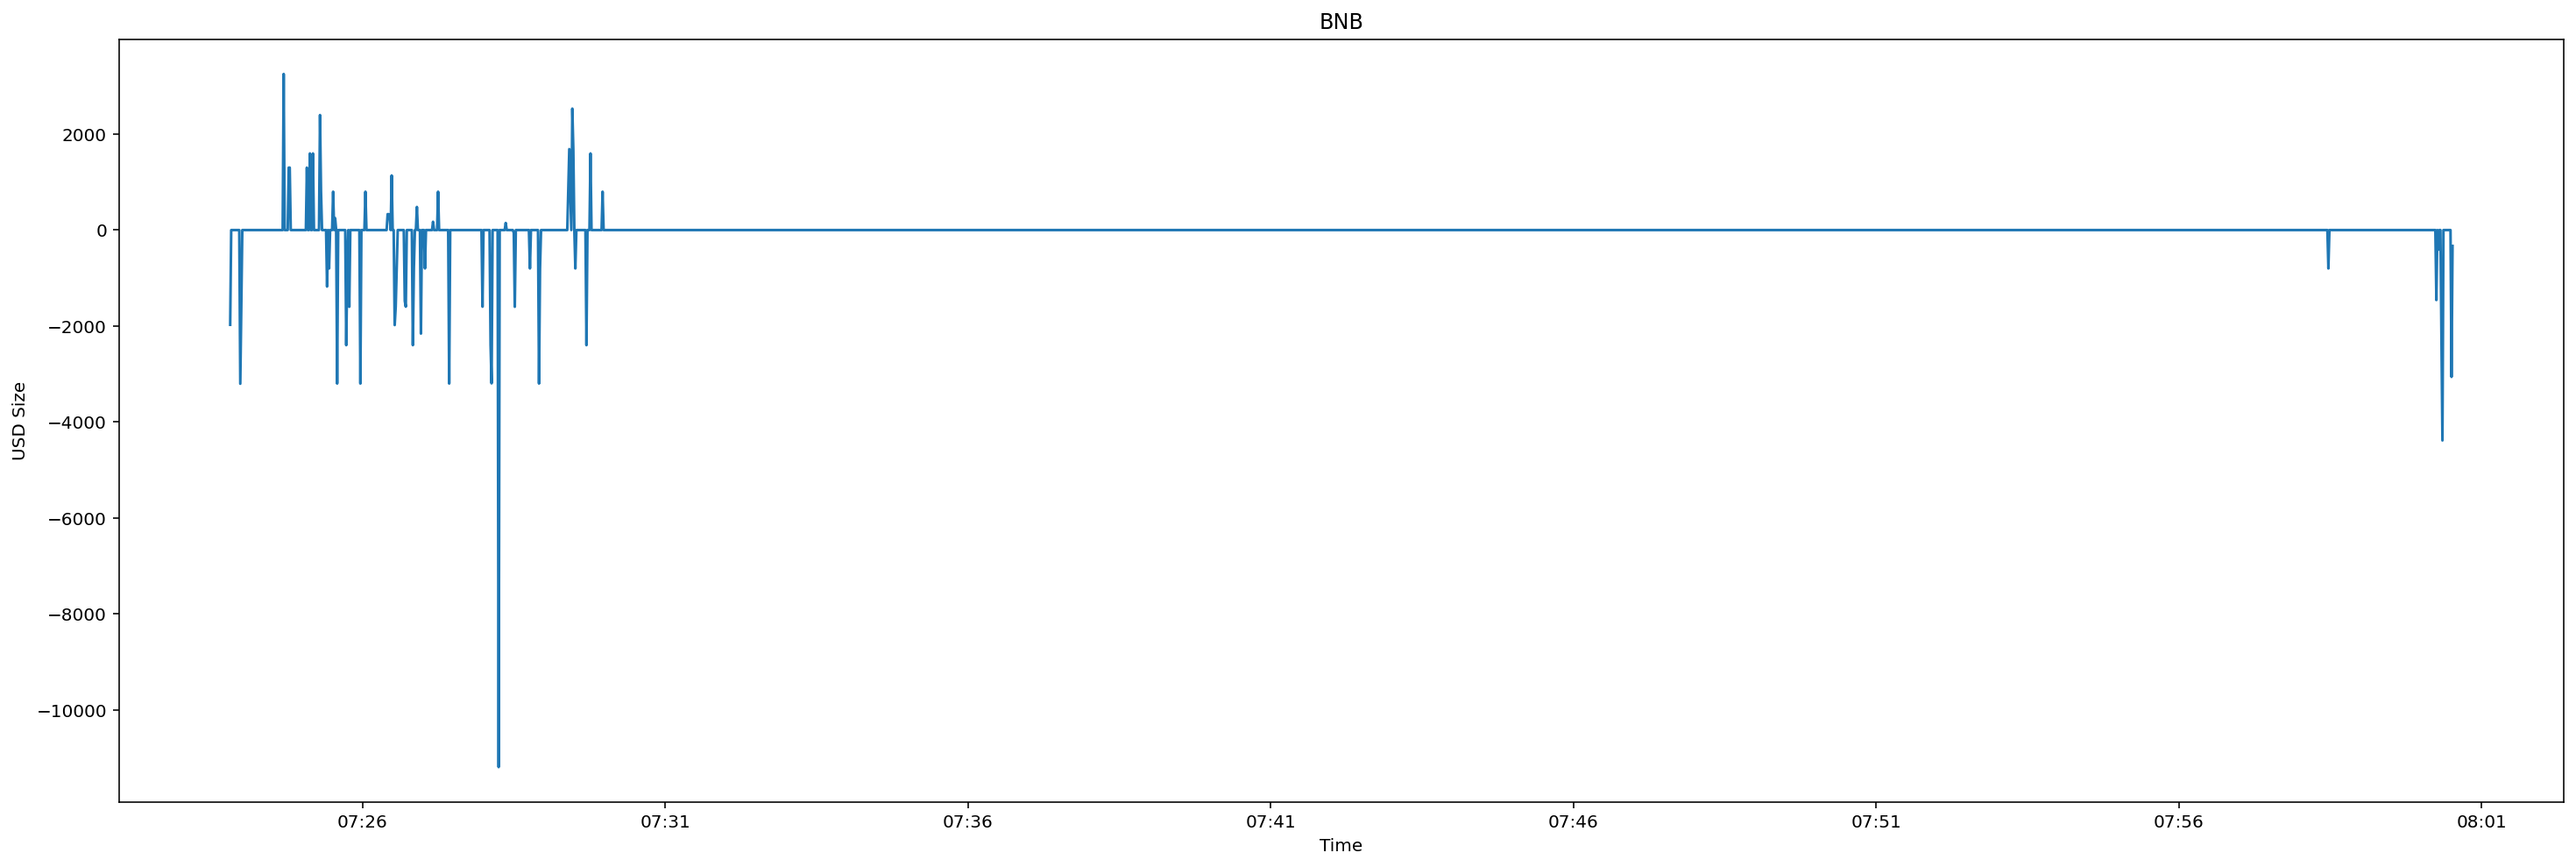

In [12]:
%config InlineBackend.figure_format = 'retina' # 提高图片质量
# 如果需要调整图片比例，可以使用下面的代码
plt.rcParams['figure.figsize'] = [25, 8] # 设置图片宽度为8英寸，高度为4英寸

# 绘制时间序列图像
def plot_time_series(df,title,graph='line'):
    # 设置x轴和y轴
    x = df.index
    y = df['usd_size']

    # 绘制折线图
    if graph=='line':
        plt.plot(x, y)
    elif graph=='scatter':
        plt.scatter(x,y)

    # 设置图像标题和x,y轴标签
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("USD Size")

    # 设置x轴刻度格式
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # 设置x轴刻度间隔为10分钟
    plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5))

    # 显示图像
    plt.show()


orders=pd.read_excel('../cache/'+'交易结果表单2.xlsx')
orders['start time']=pd.to_datetime(orders['start time'])
coin='BNB'
df=orders[(~orders.index.isin(hedge_idx)) & (orders['currency']==coin) ]

df=df.groupby(['start time']).agg({'usd_size': 'sum'})    ## 同一秒记录size值相加
df.index = pd.to_datetime(df.index)   ## 索引转datetime类型
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='1s')  ## 创建一个新的时间序列，包含缺失的时间点
df = df.reindex(date_range, fill_value=0)  ## 使用 reindex() 方法将原始时间序列重新索引，并将缺失的时间点填充为 0

plot_time_series(df,title=str(coin))

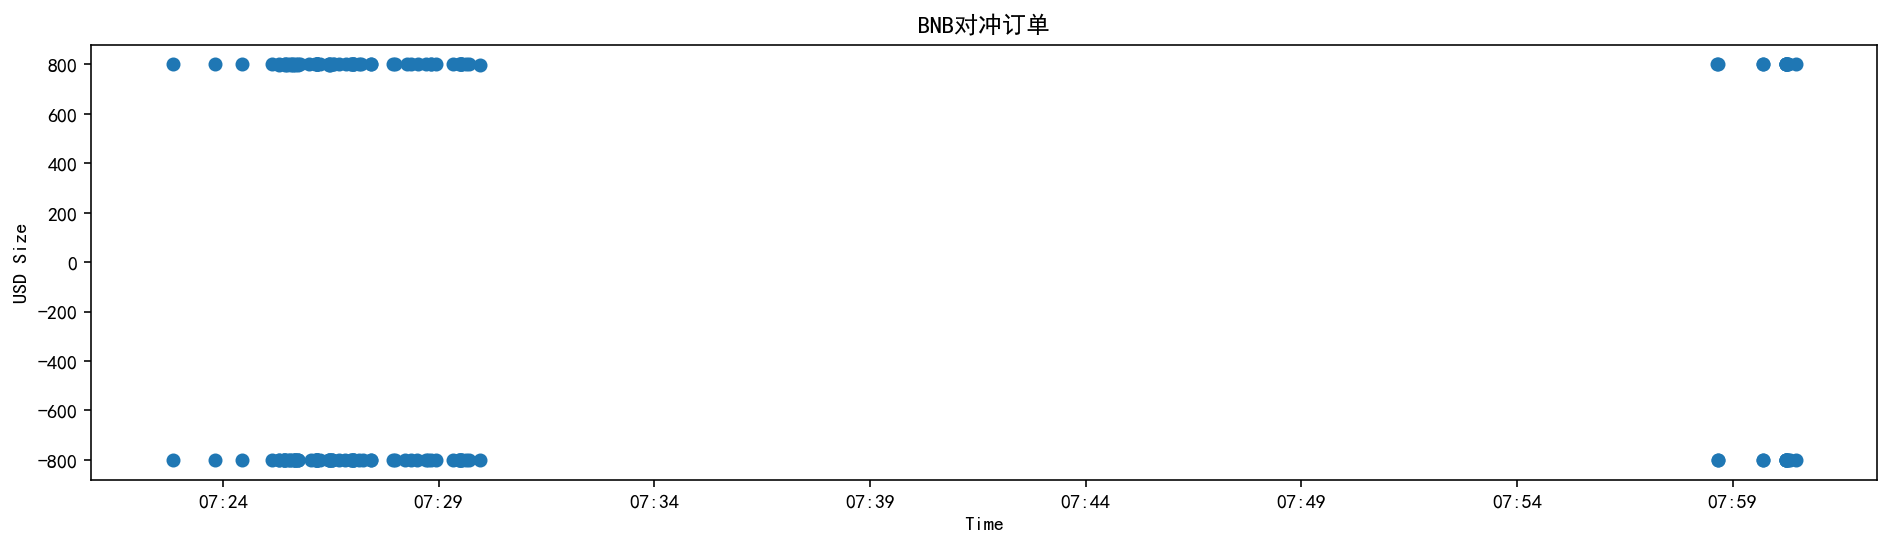

In [16]:
%config InlineBackend.figure_format = 'retina' # 提高图片质量
# 如果需要调整图片比例，可以使用下面的代码
#####################################
from matplotlib import rcParams
rcParams['font.family'] = 'SimHei'
rcParams['axes.unicode_minus'] =False
rcParams['figure.figsize'] = [16, 4] # 设置图片宽度为8英寸，高度为4英寸
#####################################
coin='BNB'
df_hedge=orders[(orders.index.isin(hedge_idx)) & (orders['currency']==coin) ]
df_hedge.index = pd.to_datetime(df_hedge['start time'])   ## 索引转datetime类型
plot_time_series(df_hedge,title='BNB对冲订单',graph='scatter')

### 用dtw匹配做多策略和做空策略

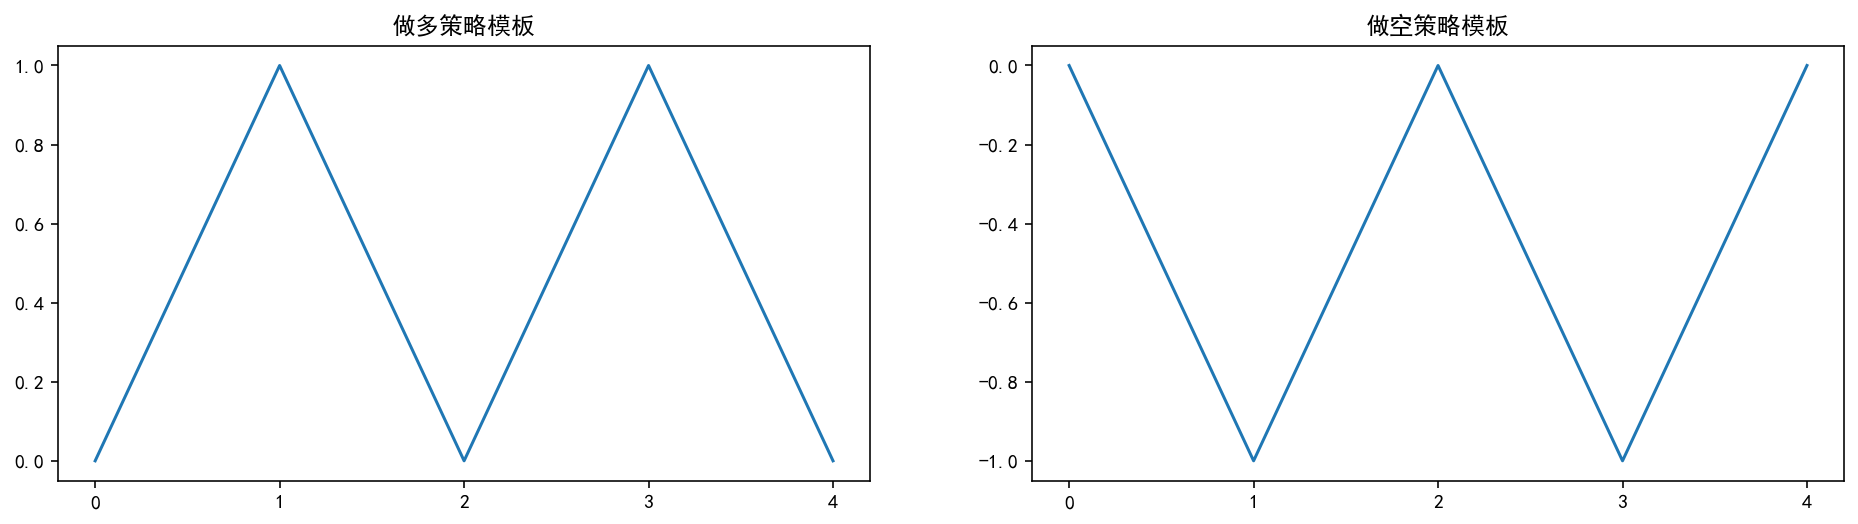

In [5]:
%config InlineBackend.figure_format = 'retina' # 提高图片质量
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
#####################################
from matplotlib import rcParams
rcParams['font.family'] = 'SimHei'
rcParams['axes.unicode_minus'] =False
# rcParams['figure.figsize'] = [25, 8]
#####################################

y = np.array(([0,1,0,1,0],
              [0,-1,0,-1,0],
                            ))

# 绘制左右子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# 左子图
ax1.plot(y[0,:])
ax1.set_title('做多策略模板')
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# 右子图
ax2.plot(y[1,:])
ax2.set_title('做空策略模板')
ax2.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# 显示图形
plt.show()

In [11]:
from dtw import dtw
from tqdm import tqdm

x = np.array(df['usd_size']).reshape(-1, 1)
y = np.array(([0,1,0,1,0],
              [0,-1,0,-1,0],
                            ))

def GiveD(x,y):
    manhattan_distance = lambda x, y: np.abs(x - y)  ## 曼哈顿距离定义
    ## 计算出总距离，耗费矩阵，累计耗费矩阵，在矩阵上的路径
    d, cost_matrix, acc_cost_matrix, path = dtw(x, y, dist=manhattan_distance)

    return d

def match(x,y,min_len=4,max_len=60):
    records=[]
    for i in range(y.shape[0]):
        for s0 in tqdm(range(len(x)-min_len)):
            if x[s0]!=0 or x[s0+1]==0: continue    ## 强制定义策略起始时为0，且第二时刻非0
            best_D=float('inf')
            best_s1='NaN'
            label='NaN'
            for s1 in range(s0+min_len,min(len(x),s0+max_len)):
                if x[s1]!=0: continue    ## 强制定义策略终止时为0
                xi=x[s0:s1]/np.abs(x[s0:s1+1]).max()    ## 值域压缩到[-1,1]
            
                d=GiveD(xi,y[i])
                if d<best_D:
                    best_D=d
                    best_s1=s1
                    label=i+1
            if best_s1!='NaN':
                records.append((s0,best_s1,best_D,label,x[s0:best_s1+1]))
    records.sort(key=lambda x: x[1])     ## 按照结束时间对元组进行排序
    return records

records=match(x,y)



100%|██████████| 2199/2199 [00:02<00:00, 1067.07it/s]


### 移除dtw值更大的重合策略

In [12]:
import math

## 贪心算法去重，不考虑留存元组的d
def remove_overlap_greedy(records):
    records.sort(key=lambda x: x[1])     ## 按照结束时间对元组进行排序
    new_records = [records[0]]
    for i in range(1, len(records)):
        start, end, effect = records[i][0:3]
        prev_start, prev_end, prev_effect = new_records[-1][0:3]
        ## 当前三元组和前一个三元组没有重合就纳入
        if start > prev_end:        
            new_records.append(records[i])
        else:
            continue
    return new_records

## 动态规划去重，考虑留存元组的d
def remove_overlap_dp(records,penalty=lambda x: np.arctan(x)):
    ## 将所有时间区间按结束时间进行排序
    records.sort(key=lambda x: x[1])
    
    n = len(records)
    dp = [1/(interval[2]+1e-2)+penalty(interval[1]-interval[0]) for interval in records]
    k = [i-1 for i in range(n)]
    
    for i in range(1, n):
        temp1=[]
        temp2=[]
        for j in range(i):
            if records[j][1] <= records[i][0]:      ## 不互斥直接添加上去
                temp1.append(dp[j]+dp[i])
                temp2.append(j)
            else:                                  ## 互斥
                temp1.append(dp[j])
                temp2.append(-1)
        temp1=np.array(temp1)
        dp[i]=temp1.max()
        # k[i]=temp2[np.where(temp1==temp1.max())[0][-1]]
        k[i]=temp2[temp1.argmax()]
        # if records[i][0]==159: print('aaaaa',temp1,temp2,dp[:i+1],k[i])
    
    # print(k)
    # 回溯选择的时间段
    res = []
    idx = np.argmax(np.array(dp))
    while idx >= 0:
        # print(idx,k[idx])
        res.append(records[idx])
        idx = k[idx]

    return list(reversed(res))

def get_gaps(records,whole_range):

    starts = [interval[0] for interval in records]
    ends = [interval[1] for interval in records] 
    gaps = [(whole_range[0],records[0][0])]
    for i in range(len(starts)-1):
        if ends[i]<starts[i+1]:
           gaps += [(ends[i],starts[i+1])]
    gaps +=  [(records[-1][1],whole_range[1])]
    return gaps

# print('去重前策略覆盖：')
# gap=get_gaps(records,[0,len(x)])
# for item in records:
#     start,end,d=item[0:3]
#     print(start,end,x[start:end+1].T,'d=',d)
# print('\n')

print('#####################greedy去重#####################')
print('去重后策略不覆盖：')
new_records=remove_overlap_greedy(records)
gap=get_gaps(new_records,[0,len(x)])
for item in gap:
    start,end=item[0:2]
    print(start,end,x[start:end+1].T)

print('\n#####################动态规划去重######################')
new_records=remove_overlap_dp(records)
print('去重后策略不覆盖：')
gap=get_gaps(new_records,[0,len(x)])
for item in gap:
    start,end=item[0:2]
    print(start,end,x[start:end+1].T)

print('去重后策略覆盖：')
for item in new_records:
    start,end=item[0:2]
    print(start,end,x[start:end+1].T)




#####################E-greedy去重#####################
去重后策略不覆盖：
0 9 [[-1975     0     0     0     0     0     0     0     0     0]]
13 52 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]]
56 57 [[0 0]]
61 75 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
81 88 [[   0 1598    0    0    0    0    0    0]]
92 95 [[0 0 0 0]]
100 101 [[0 0]]
105 114 [[    0 -3200     0     0     0     0     0     0     0     0]]
119 128 [[0 0 0 0 0 0 0 0 0 0]]
132 133 [[0 0]]
137 155 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
162 172 [[    0 -1981 -1600  -800     0     0     0     0     0     0     0]]
176 180 [[0 0 0 0 0]]
187 188 [[0 0]]
195 200 [[0 0 0 0 0 0]]
208 216 [[0 0 0 0 0 0 0 0 0]]
220 249 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
253 257 [[0 0 0 0 0]]
268 272 [[0 0 0 0 0]]
276 280 [[0 0 0 0 0]]
284 296 [[0 0 0 0 0 0 0 0 0 0 0 0 0]]
300 305 [[0 0 0 0 0 0]]
309 334 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
338 341 [[   0 2532 1685    0]]
355

In [14]:
## 1. 做市策略与orders上
strategies = np.zeros(len(x))
s_group = np.zeros(len(x))
for idx,item in enumerate(new_records):
    start, end,_, value=item[0:4]
    strategies[start:end+1]=value
    s_group[start:end+1]=idx+1
df['Market Making']=strategies
df['MMgroup']=s_group
df['Market Making']=df['Market Making'].map({0.0:np.nan , 1.0:'up' , 2.0:'down'})
sub_df=df.loc[:, ['Market Making','MMgroup']].rename_axis('start time').reset_index()
sub_df['currency']=coin
od2=pd.merge(orders, sub_df, on=['start time','currency'], how='left')

## 2. hedge策略根据索引和orders拼接
od2['hedge'] = orders.index.isin(hedge_idx).astype(int)
od2['start time'] = od2['start time'].dt.strftime('%Y-%m-%d %H:%M:%S')
od2.to_excel('../cache/交易结果表单3.xlsx',index=False)

## 3. 画图数据生成
market_data=pd.read_hdf('../cache/'+coin+'_Trade.hdf', 'data')
market_data['time']=pd.to_datetime(market_data['time'].astype('str').str.slice(0,10).astype('int64'),unit='s')
market_data=market_data.drop_duplicates(subset=['time'],keep='first')  ## 市场数据降采样到秒
ts=pd.merge(market_data[['time','bid1_price']], sub_df, left_on='time',right_on='start time', how='right')
ts.drop('time', axis=1, inplace=True)  ## 删除ts中的’time‘
od2['start time']=pd.to_datetime(od2['start time'])
ts=pd.merge(ts,od2[od2['currency']==coin][['T','start time','hedge','size','filled_size','price']],on='start time',how='left')
ts['hedge'].fillna(0,inplace=True)
ts['start time'] = ts['start time'].dt.strftime('%Y-%m-%d %H:%M:%S')
ts.to_excel('../cache/'+coin+'_策略图数据.xlsx',index=False)
ts.to_csv('../frontend/public/dataset/策略图数据.csv',index=False)